In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import time
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
train_transform = transforms.Compose([
    #transforms.Resize(96),
    #transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

test_transform = transforms.Compose([
    
    #transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])


In [3]:
root = 'C:/Users/ENES DORUK/Desktop/FaceExpressions'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'validation'), transform=test_transform)



torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=30, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=30,pin_memory=True)

dataset_sizes = 35000

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4608, 7)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)


In [6]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load("C:/Users/ENES DORUK/Desktop/FaceExpressions/savemodel/model_98.pth"))
cnn.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4608, out_features=7, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
cnn.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4608, out_features=7, bias=True)
)

In [9]:
epochs = 1
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [10]:
train_loss = []
test_loss = []
train_correct = []
test_correct = []

def train(cnn):
    start = time.time()
    for epoch in range(epochs): 
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        trn_corr = 0
        tst_corr = 0
        correct = 0
        total = 0
        running_correct = 0
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = cnn(inputs)
            total += labels.size(0)
            predicted = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)
            correct += (predicted == labels).sum().item()
            tst_corr += correct

            
            loss.backward()
            optimizer.step()
        
            if epoch % 2 == 0:
                torch.save(cnn.state_dict(), 'C:/Users/ENES DORUK/Desktop/FaceExpressions/savemodel/model_{}.pth'.format(epoch))
                #torch.save(optimizer.state_dict(), 'optimizer.pth')
                #print('|'*total)
                print('Total=========',len(train_loader))
                #print('|'*loss)
                print('Loss==========',loss)
                #print('|'*tst_corr)
                print('correct=======',tst_corr)
                #print('|'*((tst_corr//total)*100))
                print('Accuracy=========', (tst_corr//len(train_loader))*100)
                
            #running_loss += loss.item() * inputs.size(0)
            #running_correct += torch.sum(predicted == labels.data)
            #train_correct.append(correct)    
            #train_loss.append(loss)
            #train_correct.append(trn_corr)
    
    end = time.time()
    
    epoch_loss = running_loss / dataset_sizes
    epoch_acc = running_correct / dataset_sizes
    print("Loss: {} Acc: {}".format(epoch_loss, epoch_acc))
    
    
    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
    return cnn
    

train(cnn)

Epoch 0/0
----------
Total========= 961
Loss========== tensor(0.6676, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 23
Accuracy========= 0
Total========= 961
Loss========== tensor(0.9649, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 67
Accuracy========= 0
Total========= 961
Loss========== tensor(0.5702, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 134
Accuracy========= 0
Total========= 961
Loss========== tensor(0.8387, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 226
Accuracy========= 0
Total========= 961
Loss========== tensor(0.6475, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 340
Accuracy========= 0
Total========= 961
Loss========== tensor(0.2739, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 481
Accuracy========= 0
Total========= 961
Loss========== tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 642
Accuracy========= 0
Total========= 961
Loss========== tensor(0.6139, device='

Total========= 961
Loss========== tensor(0.3956, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 53944
Accuracy========= 5600
Total========= 961
Loss========== tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 55591
Accuracy========= 5700
Total========= 961
Loss========== tensor(0.2222, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 57264
Accuracy========= 5900
Total========= 961
Loss========== tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 58963
Accuracy========= 6100
Total========= 961
Loss========== tensor(0.7837, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 60685
Accuracy========= 6300
Total========= 961
Loss========== tensor(0.4668, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 62430
Accuracy========= 6400
Total========= 961
Loss========== tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 64202
Accuracy========= 6600
Total========= 961
Loss========== tensor(

Total========= 961
Loss========== tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 212033
Accuracy========= 22000
Total========= 961
Loss========== tensor(0.3296, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 215277
Accuracy========= 22400
Total========= 961
Loss========== tensor(0.4272, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 218546
Accuracy========= 22700
Total========= 961
Loss========== tensor(0.4877, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 221840
Accuracy========= 23000
Total========= 961
Loss========== tensor(0.4616, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 225159
Accuracy========= 23400
Total========= 961
Loss========== tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 228501
Accuracy========= 23700
Total========= 961
Loss========== tensor(0.4183, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 231868
Accuracy========= 24100
Total========= 961
Loss====

Total========= 961
Loss========== tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 445919
Accuracy========= 46400
Total========= 961
Loss========== tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 450617
Accuracy========= 46800
Total========= 961
Loss========== tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 455338
Accuracy========= 47300
Total========= 961
Loss========== tensor(0.4794, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 460084
Accuracy========= 47800
Total========= 961
Loss========== tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 464850
Accuracy========= 48300
Total========= 961
Loss========== tensor(0.4089, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 469641
Accuracy========= 48800
Total========= 961
Loss========== tensor(0.7627, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 474451
Accuracy========= 49300
Total========= 961
Loss====

Total========= 961
Loss========== tensor(0.4760, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 783831
Accuracy========= 81500
Total========= 961
Loss========== tensor(0.7183, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 790058
Accuracy========= 82200
Total========= 961
Loss========== tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 796310
Accuracy========= 82800
Total========= 961
Loss========== tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 802585
Accuracy========= 83500
Total========= 961
Loss========== tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 808888
Accuracy========= 84100
Total========= 961
Loss========== tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 815213
Accuracy========= 84800
Total========= 961
Loss========== tensor(0.2844, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 821565
Accuracy========= 85400
Total========= 961
Loss====

Loss========== tensor(0.8384, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1208730
Accuracy========= 125700
Total========= 961
Loss========== tensor(0.3564, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1216469
Accuracy========= 126500
Total========= 961
Loss========== tensor(0.3699, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1224234
Accuracy========= 127300
Total========= 961
Loss========== tensor(0.5862, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1232020
Accuracy========= 128200
Total========= 961
Loss========== tensor(0.2794, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1239833
Accuracy========= 129000
Total========= 961
Loss========== tensor(0.4383, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1247672
Accuracy========= 129800
Total========= 961
Loss========== tensor(0.3410, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1255537
Accuracy========= 130600
Total========= 961
Loss=========

Total========= 961
Loss========== tensor(0.3521, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1734802
Accuracy========= 180500
Total========= 961
Loss========== tensor(0.3970, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1744075
Accuracy========= 181400
Total========= 961
Loss========== tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1753373
Accuracy========= 182400
Total========= 961
Loss========== tensor(0.7691, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1762694
Accuracy========= 183400
Total========= 961
Loss========== tensor(0.4327, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1772041
Accuracy========= 184300
Total========= 961
Loss========== tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1781410
Accuracy========= 185300
Total========= 961
Loss========== tensor(0.3983, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 1790804
Accuracy========= 186300
Total========

Total========= 961
Loss========== tensor(0.5711, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2354292
Accuracy========= 244900
Total========= 961
Loss========== tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2365027
Accuracy========= 246100
Total========= 961
Loss========== tensor(0.7038, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2375783
Accuracy========= 247200
Total========= 961
Loss========== tensor(0.4112, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2386563
Accuracy========= 248300
Total========= 961
Loss========== tensor(0.5274, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2397366
Accuracy========= 249400
Total========= 961
Loss========== tensor(0.5679, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2408190
Accuracy========= 250500
Total========= 961
Loss========== tensor(0.7799, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 2419036
Accuracy========= 251700
Total========

Loss========== tensor(0.4147, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3088632
Accuracy========= 321300
Total========= 961
Loss========== tensor(0.4264, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3100876
Accuracy========= 322600
Total========= 961
Loss========== tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3113141
Accuracy========= 323900
Total========= 961
Loss========== tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3125432
Accuracy========= 325200
Total========= 961
Loss========== tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3137745
Accuracy========= 326500
Total========= 961
Loss========== tensor(0.8962, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3150077
Accuracy========= 327700
Total========= 961
Loss========== tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3162429
Accuracy========= 329000
Total========= 961
Loss=========

Total========= 961
Loss========== tensor(0.6489, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3864085
Accuracy========= 402000
Total========= 961
Loss========== tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3877722
Accuracy========= 403500
Total========= 961
Loss========== tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3891385
Accuracy========= 404900
Total========= 961
Loss========== tensor(0.6458, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3905071
Accuracy========= 406300
Total========= 961
Loss========== tensor(0.6360, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3918782
Accuracy========= 407700
Total========= 961
Loss========== tensor(0.9440, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3932515
Accuracy========= 409200
Total========= 961
Loss========== tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 3946269
Accuracy========= 410600
Total========

Loss========== tensor(0.7949, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4785426
Accuracy========= 497900
Total========= 961
Loss========== tensor(0.6832, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4800583
Accuracy========= 499500
Total========= 961
Loss========== tensor(0.8391, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4815761
Accuracy========= 501100
Total========= 961
Loss========== tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4830963
Accuracy========= 502700
Total========= 961
Loss========== tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4846189
Accuracy========= 504200
Total========= 961
Loss========== tensor(0.5164, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4861438
Accuracy========= 505800
Total========= 961
Loss========== tensor(0.4074, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 4876712
Accuracy========= 507400
Total========= 961
Loss=========

Total========= 961
Loss========== tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5719844
Accuracy========= 595100
Total========= 961
Loss========== tensor(0.4241, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5736391
Accuracy========= 596900
Total========= 961
Loss========== tensor(0.3433, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5752965
Accuracy========= 598600
Total========= 961
Loss========== tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5769564
Accuracy========= 600300
Total========= 961
Loss========== tensor(0.4352, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5786190
Accuracy========= 602100
Total========= 961
Loss========== tensor(0.9555, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5802840
Accuracy========= 603800
Total========= 961
Loss========== tensor(0.3921, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 5819516
Accuracy========= 605500
Total========

Total========= 961
Loss========== tensor(0.5614, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6845715
Accuracy========= 712300
Total========= 961
Loss========== tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6863821
Accuracy========= 714200
Total========= 961
Loss========== tensor(0.7958, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6881949
Accuracy========= 716100
Total========= 961
Loss========== tensor(0.4099, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6900103
Accuracy========= 718000
Total========= 961
Loss========== tensor(0.5598, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6918281
Accuracy========= 719900
Total========= 961
Loss========== tensor(0.9909, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6936480
Accuracy========= 721700
Total========= 961
Loss========== tensor(0.4194, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 6954706
Accuracy========= 723600
Total========

Total========= 961
Loss========== tensor(0.3610, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 7972242
Accuracy========= 829500
Total========= 961
Loss========== tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 7991736
Accuracy========= 831600
Total========= 961
Loss========== tensor(0.4323, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 8011255
Accuracy========= 833600
Total========= 961
Loss========== tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 8030797
Accuracy========= 835600
Total========= 961
Loss========== tensor(0.4109, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 8050363
Accuracy========= 837700
Total========= 961
Loss========== tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 8069953
Accuracy========= 839700
Total========= 961
Loss========== tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 8089566
Accuracy========= 841700
Total========

Total========= 961
Loss========== tensor(0.9113, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9161696
Accuracy========= 953300
Total========= 961
Loss========== tensor(0.8198, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9182559
Accuracy========= 955500
Total========= 961
Loss========== tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9203448
Accuracy========= 957600
Total========= 961
Loss========== tensor(0.2266, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9224366
Accuracy========= 959800
Total========= 961
Loss========== tensor(0.6314, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9245308
Accuracy========= 962000
Total========= 961
Loss========== tensor(0.4713, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9266276
Accuracy========= 964200
Total========= 961
Loss========== tensor(0.5238, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 9287268
Accuracy========= 966400
Total========

Total========= 961
Loss========== tensor(0.3612, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10433133
Accuracy========= 1085600
Total========= 961
Loss========== tensor(0.6114, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10455396
Accuracy========= 1087900
Total========= 961
Loss========== tensor(0.5288, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10477683
Accuracy========= 1090200
Total========= 961
Loss========== tensor(0.5403, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10499992
Accuracy========= 1092600
Total========= 961
Loss========== tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10522322
Accuracy========= 1094900
Total========= 961
Loss========== tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10544676
Accuracy========= 1097200
Total========= 961
Loss========== tensor(0.3321, device='cuda:0', grad_fn=<NllLossBackward>)
correct======= 10567057
Accuracy========= 1099500

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4608, out_features=7, bias=True)
)

In [11]:
def predict_image(image):
    image_tensor = test_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn(input)
    index = output.data.cpu().numpy().argmax()
    return index


In [12]:
def get_random_images(num):
    
    class_names = train_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

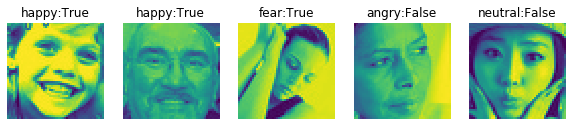

In [13]:
to_pil = transforms.ToPILImage()
class_names = train_data.classes
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()